In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

/home/eurastof/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import multiprocessing
n_jobs = multiprocessing.cpu_count() - 1


## Making coordinate data (common atoms)

traj_dirs = ["/wrk/eurastof/binding_spots_project/validation/a2ar_site_*",
             "/wrk/eurastof/binding_spots_project/validation/d2_site_*",
             "/wrk/eurastof/binding_spots_project/validation/d3_site_*",
             "/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/*"]
gro_ext = ["/run*/aligned.gro", "/run*/aligned.gro", "/run*/aligned.gro", "/*gro"]
xtc_ext = ["/run*/aligned.xtc", "/run*/aligned.xtc", "/run*/aligned.xtc", "/*xtc"]

ndx_files = ["/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/a2ar_common.ndx",
             "/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/d2_common.ndx",
             "/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/d3_common.ndx",
             "/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/b2ar_common.ndx"
            ]
skips = [50, 50, 50, 10]

ref = mda.Universe("/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/popc/step6.6_equilibration.gro")
with open("/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/b2ar_common.ndx") as f:
        lines = "".join(f.readlines())
ref_resids = " ".join(re.findall(r"\d+", lines)[1:])

ids = []

for i, p in  enumerate(traj_dirs):
    print(p)
    skip = skips[i]
    for d in glob.glob(p):
        gro = glob.glob(d + gro_ext[i])[0]
        xtcs = glob.glob(d + xtc_ext[i])
        cosmos = mda.Universe(gro, xtcs)
        mean_length = np.mean([mda.Universe(gro, xtc).trajectory[-1].time/1000000 for xtc in xtcs])
        print(f"Avg. traj. length {mean_length}")     
        for ts in cosmos.trajectory[0:-1:skip]:
            ids.append(i)

np.save("./all_proteins_ids.npy", np.array(ids))            
"""coordinates = []

for i, p in  enumerate(traj_dirs):
    
    with open(ndx_files[i]) as f:
        lines = "".join(f.readlines())

    resids = " ".join(re.findall(r"\d+", lines)[1:])
    skip = skips[i]
    
    for d in glob.glob(p):
        gro = glob.glob(d + gro_ext[i])[0]
        xtcs = glob.glob(d + xtc_ext[i])
        
        cosmos = mda.Universe(gro, xtcs)
        common_ca = cosmos.select_atoms(f"bynum {resids}")
        
        for ts in cosmos.trajectory[0:-1:skip]:
            align.alignto(cosmos, ref, select=(f"bynum {resids}", f"bynum {ref_resids}"), tol_mass=100)
            coords = common_ca.positions.flatten()
            coordinates.append(coords.reshape(1, coords.shape[0]))

X = np.concatenate(coordinates)
np.save("./a2ar_b2ar_common_ca_coordinates.npy", X)
"""



## Autoencoder pipeline

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


import torch
from torch import nn, optim

import random


In [4]:

class Autoencoder(BaseEstimator, TransformerMixin, nn.Module):

    def __init__(self, in_shape=10, enc_shape=2, middle_shape=5, n_hidden=1, loss_fn=nn.L1Loss(), lr=1e-3):
        
        super().__init__()
        self.loss_fn = loss_fn
        self.lr = lr
        self.n_hidden = n_hidden
        self.in_shape = in_shape
        self.enc_shape = enc_shape
        self.middle_shape = middle_shape
        
        encoder_layers = [nn.Linear(self.in_shape, self.middle_shape), nn.ReLU(), nn.Dropout(0.2)]
        decoder_layers = [nn.Linear(self.enc_shape, self.middle_shape), nn.ReLU(), nn.Dropout(0.2)]

        for i in range(n_hidden - 1):
            encoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(0.2))
            decoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(0.2))
            
        encoder_layers.append(nn.Linear(self.middle_shape, self.enc_shape))
        decoder_layers.append(nn.Linear(self.middle_shape, self.in_shape))
        #decoder_layers.append(nn.Sigmoid())

        self.encode = nn.Sequential(*encoder_layers)
        self.decode = nn.Sequential(*decoder_layers)
        

    def fit(self, X, y=None, n_epochs=20, batch_size=32, verbose=False):
        self.training = True
        X = torch.Tensor(X)
        indices = [i for i in range(X.shape[0])]
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
        for epoch in range(n_epochs):
        
            random.shuffle(indices)
            batches = [i for i in range(0, len(indices), batch_size)]

            for i in range(len(batches) - 1):

                batch_X = X[indices[batches[i]:batches[i+1]]]
                self.optimizer.zero_grad()
                
                encoded = self.encode(batch_X)
                decoded = self.decode(encoded)

                loss = self.loss_fn(decoded, batch_X)
                loss.backward()
                self.optimizer.step()
            
            if verbose:
                print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
        
        return self

    def transform(self, X, y=None):
        encoded = self.encode(torch.Tensor(X))
        return encoded.cpu().detach().numpy()
    

    def inverse_transform(self, X, y=None):
        decoded = self.decode(torch.Tensor(X))
        return decoded.cpu().detach().numpy()
    
    def score(self, X, y=None):
        encoded = self.transform(X)
        decoded = self.inverse_transform(encoded)
        
        return -self.loss_fn(torch.Tensor(X), torch.Tensor(decoded))
        
    
    



In [5]:
param_grid = {
    "Autoencoder__middle_shape": [512, 1024, 2048],
    "Autoencoder__enc_shape": [2, 3, 4],
    "Autoencoder__n_hidden": [1, 2, 3, 4],
}

In [6]:
def pipeline(transformer, param_grid, X):
    
    pipe = Pipeline(
        steps=[
            ("Scaler", StandardScaler()),
            ("Autoencoder", transformer),
        ]   
    )
    
    gridsearch = GridSearchCV(pipe, param_grid=param_grid, verbose=3, cv=2)
    gridsearch.fit(X)
    
    return gridsearch.best_estimator_
    
    
    

In [7]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
print(f"Using {device} device.")

Using cpu device.


## Autoencoder testing

In [8]:
X = torch.Tensor(np.load("all_proteins_common_ca_coords.npy")).to(device)
ids = np.load("all_proteins_ids.npy")

In [34]:
AE = Autoencoder(in_shape=X.shape[1], enc_shape=2, middle_shape=1024, n_hidden=1)
s = StandardScaler()
X_s = s.fit_transform(X)
AE.fit(X_s, verbose=True, n_epochs=5)


epoch 0 	 Loss: 0.6097
epoch 1 	 Loss: 0.546
epoch 2 	 Loss: 0.5519
epoch 3 	 Loss: 0.4623
epoch 4 	 Loss: 0.5037


Autoencoder(in_shape=786, middle_shape=1024)

In [35]:
enc = AE.transform(X_s)
back = s.inverse_transform(AE.inverse_transform(enc))
L1 = np.mean(np.abs(np.array(X) - back))
print(L1)

1.4641749


In [36]:
# TM36 distance calculation
r1 = 92*3
r2 = 191*3
A = X[:,r1:r1+3]
B = X[:,r2:r2+3]
C = np.array(A - B)

tm36 = np.sqrt(np.sum(C**2, axis=1))


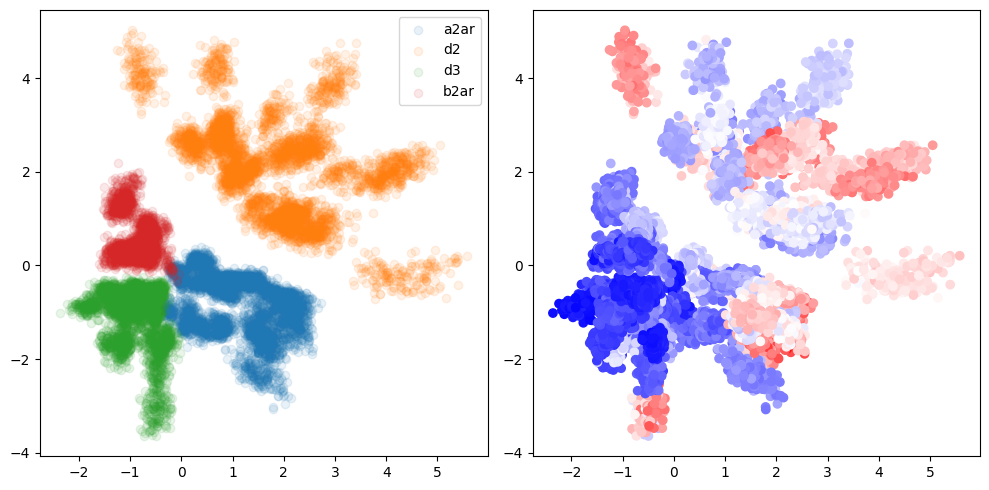

In [78]:
import itertools
names = ["a2ar", "d2", "d3", "b2ar"]

fig, ax = plt.subplots(1,2, figsize=(10, 5))
for a, b in itertools.combinations(range(enc.shape[1]), 2):

    for id in set(ids):
        
        index = np.where(np.array(ids) == id)[0]
        ax[0].scatter(enc[index, a], enc[index, b], alpha=0.5, label=names[id])

    ax[0].legend()
ax[1].scatter(enc[:,0], enc[:,1], c=tm36, cmap="bwr")
plt.tight_layout()
plt.show()